In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="fNh37dV1D0lUqlJYGKHa")
project = rf.workspace("xray-u9rf3").project("wsiroisimages")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
pip install segmentation-models-pytorch

In [ ]:
import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp

# Determine if GPU is available, otherwise fall back to CPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cpu


## Define Tissue Segmentation Model

### Subtask:
Implement `get_tissue_model()` returning an `smp.Unet` with `encoder='efficientnet-b0'`, `encoder_weights='imagenet'`, and `classes=3`. Mock a forward pass with a dummy tensor of shape `(1, 3, 512, 512)` to simulate tissue segmentation output.


In [ ]:
def get_tissue_model():
    model = smp.Unet(
        encoder_name="efficientnet-b0",
        encoder_weights="imagenet",
        classes=3,
        activation=None,
    )
    return model.to(DEVICE)

# Instantiate the tissue segmentation model
tissue_model = get_tissue_model()
print(f"Tissue segmentation model created and moved to {DEVICE}.")

# Create a dummy input tensor and move it to the device
dummy_input = torch.randn(1, 3, 512, 512).to(DEVICE)
print(f"Dummy input tensor created with shape {dummy_input.shape} and moved to {DEVICE}.")

# Perform a forward pass
with torch.no_grad():
    tissue_output = tissue_model(dummy_input)

# Print the shape of the output
print(f"Shape of tissue segmentation model output: {tissue_output.shape}")


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Tissue segmentation model created and moved to cpu.
Dummy input tensor created with shape torch.Size([1, 3, 512, 512]) and moved to cpu.
Shape of tissue segmentation model output: torch.Size([1, 3, 512, 512])


In [ ]:
def get_til_model():
    model = smp.Unet(
        encoder_name="efficientnet-b0",
        encoder_weights="imagenet",
        classes=1,
        activation=None,
    )
    return model.to(DEVICE)

# Instantiate the TIL detection model
til_model = get_til_model()
print(f"TIL detection model created and moved to {DEVICE}.")

# Create a dummy input tensor and move it to the device
dummy_input = torch.randn(1, 3, 512, 512).to(DEVICE)
print(f"Dummy input tensor created with shape {dummy_input.shape} and moved to {DEVICE}.")

# Perform a forward pass
with torch.no_grad():
    til_output = til_model(dummy_input)

# Print the shape of the output
print(f"Shape of TIL detection model output: {til_output.shape}")

TIL detection model created and moved to cpu.
Dummy input tensor created with shape torch.Size([1, 3, 512, 512]) and moved to cpu.
Shape of TIL detection model output: torch.Size([1, 1, 512, 512])


## Centroid Extraction

### Subtask:
Implement `extract_centroids(prob_map, threshold=0.5)` using `cv2.connectedComponentsWithStats` to find TIL centroids.

#### Instructions:
1. Define a function `extract_centroids(prob_map, threshold=0.5)` that takes a 2D probability map (numpy array) and a threshold as input.
2. Inside the function, convert the probability map to a binary mask using the provided `threshold`.
3. Use `cv2.connectedComponentsWithStats` on the binary mask to find connected components, their stats, and centroids.
4. Filter out background components (usually component 0) and return a list of (x, y) coordinates for the centroids of detected objects.
5. Create a dummy `prob_map` (e.g., a 512x512 numpy array with some regions above the threshold) to test the function.
6. Call `extract_centroids()` with the dummy `prob_map` and print the resulting list of centroids.

In [ ]:
def extract_centroids(prob_map, threshold=0.5):
    # Convert probability map to binary mask
    # Scale to 255 for cv2 functions, then convert to uint8
    binary_mask = (prob_map > threshold).astype(np.uint8) * 255

    # Find connected components and their stats
    # num_labels: total number of labeled components
    # labels: an array where each pixel has the label of its connected component
    # stats: an array with statistics for each label, including bounding box and area
    # centroids: an array with the (x, y) centroid coordinates for each label
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, 8, cv2.CV_32S)

    til_centroids = []
    # Iterate through each component, skipping the background (label 0)
    for i in range(1, num_labels):
        # Centroids are returned as (x, y) in OpenCV
        center_x = int(centroids[i, 0])
        center_y = int(centroids[i, 1])
        til_centroids.append((center_x, center_y))

    return til_centroids

# Create a dummy probability map for testing (512x512)
dummy_prob_map = np.zeros((512, 512), dtype=np.float32)

# Add some regions above the threshold to simulate TILs
dummy_prob_map[100:110, 100:110] = 0.6  # Small square
dummy_prob_map[200:220, 300:330] = 0.7  # Larger rectangle
dummy_prob_map[400:405, 50:55] = 0.8    # Tiny square

# Extract centroids from the dummy probability map
centroids = extract_centroids(dummy_prob_map, threshold=0.5)

print(f"Detected TIL centroids: {centroids}")

Detected TIL centroids: [(104, 104), (314, 209), (52, 402)]


## TILScorer Class (TIGER Algorithm)

### Subtask:
Implement a `TILScorer` class with a `compute_score(tumor_mask, stroma_mask, til_centroids)` method. This method should perform morphological dilation on the tumor mask, calculate 'Relevant Stroma', filter TILs within this region, and compute the TIL score as `(Filtered_TIL_Count * 16 / Area_Relevant_Stroma) * 100` (returning an integer between 0-100).


In [ ]:
class TILScorer:
    def compute_score(self, tumor_mask, stroma_mask, til_centroids):
        # 3a. Create a structuring element for morphological operations
        kernel_size = 7 # Example kernel size
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

        # 3b. Perform morphological dilation on the tumor_mask
        expanded_tumor_region = cv2.dilate(tumor_mask, kernel, iterations=1)

        # 3c. Calculate 'Relevant Stroma'
        # Relevant Stroma = Stroma AND Expanded Tumor Region
        relevant_stroma_mask = cv2.bitwise_and(stroma_mask, expanded_tumor_region)

        # 3d. Calculate Area_Relevant_Stroma
        area_relevant_stroma = np.sum(relevant_stroma_mask > 0) # Count non-zero pixels

        if area_relevant_stroma == 0:
            print("Area of Relevant Stroma is zero. Returning TIL score of 0.")
            return 0

        # 3e. Filter til_centroids within 'Relevant Stroma' mask
        filtered_til_centroids = []
        for x, y in til_centroids:
            # Ensure coordinates are within image bounds
            if 0 <= y < relevant_stroma_mask.shape[0] and 0 <= x < relevant_stroma_mask.shape[1]:
                if relevant_stroma_mask[y, x] > 0: # Check if the centroid falls within relevant stroma
                    filtered_til_centroids.append((x, y))

        # 3f. Count the Filtered_TIL_Count
        filtered_til_count = len(filtered_til_centroids)

        # 3g. Compute the TIL score
        # Formula: (Filtered_TIL_Count * 16 / Area_Relevant_Stroma) * 100
        til_score = (filtered_til_count * 16 / area_relevant_stroma) * 100

        # Cap the score between 0 and 100 and convert to integer
        til_score = int(max(0, min(100, til_score)))

        return til_score

# 4. Create dummy inputs for testing (512x512 numpy arrays)
image_size = 512

dummy_tumor_mask = np.zeros((image_size, image_size), dtype=np.uint8)
dummy_stroma_mask = np.zeros((image_size, image_size), dtype=np.uint8)

# Add a dummy tumor region
dummy_tumor_mask[150:250, 150:250] = 1

# Add a dummy stroma region (some overlap with tumor, some outside)
dummy_stroma_mask[100:300, 100:300] = 1

# Create dummy TIL centroids, some inside relevant stroma, some outside
dummy_til_centroids = [
    (170, 170), # Inside tumor and stroma overlap -> relevant stroma
    (220, 220), # Inside tumor and stroma overlap -> relevant stroma
    (110, 110), # Inside stroma, outside tumor
    (350, 350)  # Outside both
]

# 5. Instantiate TILScorer and call compute_score()
scorer = TILScorer()
final_til_score = scorer.compute_score(
    dummy_tumor_mask,
    dummy_stroma_mask,
    dummy_til_centroids
)

print(f"Final TIL Score: {final_til_score}")

Final TIL Score: 0


## Simulate Pipeline Execution

### Subtask:
Create dummy inputs: random tensors to simulate Stage 1 (tissue map) and Stage 2 (TIL probability map) outputs. Convert these tensors to binary masks (0/1). Instantiate the `TILScorer` and run the full pipeline, printing the calculated TIL Score.


In [ ]:
print("\n--- Simulating Full Pipeline Execution ---")

# 1. Generate dummy input for tissue segmentation model
dummy_input_tissue = torch.randn(1, 3, 512, 512).to(DEVICE)
print(f"Dummy input for tissue model created with shape {dummy_input_tissue.shape} on {DEVICE}.")

# 2. Pass through tissue_model
with torch.no_grad():
    tissue_output = tissue_model(dummy_input_tissue)
print(f"Shape of simulated tissue segmentation output: {tissue_output.shape}")

# 3. Convert tissue_output to binary masks (tumor_mask and stroma_mask)
# Assuming channel 1 for tumor and channel 2 for stroma from the 3-class output
# Squeeze to remove batch dimension and move to CPU if on GPU, then convert to numpy
tissue_output_np = torch.softmax(tissue_output, dim=1).squeeze(0).cpu().numpy()

# For simplicity in simulation, let's say channel 0 is background, channel 1 is tumor, channel 2 is stroma
# Get the tumor probability map (e.g., channel 1)
tumor_prob_map = tissue_output_np[1, :, :]
# Get the stroma probability map (e.g., channel 2)
stroma_prob_map = tissue_output_np[2, :, :]

# Convert to binary masks with a threshold
threshold_tissue_mask = 0.5
pipeline_tumor_mask = (tumor_prob_map > threshold_tissue_mask).astype(np.uint8) * 255
pipeline_stroma_mask = (stroma_prob_map > threshold_tissue_mask).astype(np.uint8) * 255

print(f"Pipeline tumor mask shape: {pipeline_tumor_mask.shape}, stroma mask shape: {pipeline_stroma_mask.shape}")

# 4. Generate dummy input for TIL detection model
dummy_input_til = torch.randn(1, 3, 512, 512).to(DEVICE)
print(f"Dummy input for TIL model created with shape {dummy_input_til.shape} on {DEVICE}.")

# 5. Pass through til_model
with torch.no_grad():
    til_output = til_model(dummy_input_til)
print(f"Shape of simulated TIL detection output: {til_output.shape}")

# 6. Convert til_output to 2D NumPy array (til_probability_map)
# Squeeze to remove batch and channel dimensions (since it's 1 class) and move to CPU if on GPU, then convert to numpy
til_probability_map = torch.sigmoid(til_output).squeeze(0).squeeze(0).cpu().numpy()
print(f"Shape of TIL probability map (numpy): {til_probability_map.shape}")

# 7. Use extract_centroids() to get pipeline_til_centroids
threshold_til_detection = 0.5
pipeline_til_centroids = extract_centroids(til_probability_map, threshold=threshold_til_detection)
print(f"Extracted {len(pipeline_til_centroids)} TIL centroids for pipeline simulation.")

# 8. Instantiate the TILScorer class
pipeline_scorer = TILScorer()

# 9. Call compute_score()
final_pipeline_til_score = pipeline_scorer.compute_score(
    pipeline_tumor_mask,
    pipeline_stroma_mask,
    pipeline_til_centroids
)

# 10. Print the final calculated TIL Score
print(f"\nFinal Calculated TIL Score from Pipeline Simulation: {final_pipeline_til_score}")


--- Simulating Full Pipeline Execution ---
Dummy input for tissue model created with shape torch.Size([1, 3, 512, 512]) on cpu.
Shape of simulated tissue segmentation output: torch.Size([1, 3, 512, 512])
Pipeline tumor mask shape: (512, 512), stroma mask shape: (512, 512)
Dummy input for TIL model created with shape torch.Size([1, 3, 512, 512]) on cpu.
Shape of simulated TIL detection output: torch.Size([1, 1, 512, 512])
Shape of TIL probability map (numpy): (512, 512)
Extracted 11 TIL centroids for pipeline simulation.

Final Calculated TIL Score from Pipeline Simulation: 0


## Define InferenceDataset

### Subtask:
Define a custom PyTorch `InferenceDataset` class that loads images from the validation set folder, resizes them to 512x512, and converts them to PyTorch tensors suitable for model input.


In [ ]:
import torch
import torchvision.transforms as transforms
import os
import cv2
from PIL import Image

class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # List all files in the directory
        all_files = os.listdir(image_dir)

        # Filter to include only common image extensions
        image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')
        self.image_paths = [
            os.path.join(image_dir, fname)
            for fname in all_files
            if fname.lower().endswith(image_extensions)
        ]

        print(f"Found {len(self.image_paths)} images in {image_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]

        # Load image using cv2.imread (BGR format)
        image_bgr = cv2.imread(image_path)

        if image_bgr is None:
            print(f"Warning: Could not load image {image_path}. Skipping.")
            return None, image_path # Return None for image if loading fails

        # Convert from BGR to RGB
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Convert NumPy array to PIL Image for torchvision.transforms compatibility
        image_pil = Image.fromarray(image_rgb)

        if self.transform:
            image_tensor = self.transform(image_pil)
        else:
            # If no transform, convert to tensor directly
            image_tensor = transforms.ToTensor()(image_pil)

        return image_tensor, image_path

# Define the transformations
TARGET_SIZE = 512
inference_transforms = transforms.Compose([
    # Resizing to 512x512 is a prototype simplification. For a production
    # clinical system, a tiling/patching strategy would be required to
    # preserve the resolution of small lymphocytes and other fine details.
    transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("InferenceDataset class and transformations defined.")


InferenceDataset class and transformations defined.


In [ ]:
from torch.utils.data import DataLoader

# Path to the validation set folder
valid_image_dir = '/content/wsiroisImages-2/valid/images'

# Initialize the InferenceDataset
inference_dataset = InferenceDataset(image_dir=valid_image_dir, transform=inference_transforms)

# Create a DataLoader for the first 5 images
# We'll limit the dataset size for this example to the first 5 images
# Note: This is a common way to subset a dataset for quick testing.
# For actual batch processing of a subset, you might use Subset(dataset, indices)

# Subsetting the dataset to the first 5 images if available
if len(inference_dataset) > 0:
    # Create a list of indices for the first 5 images
    subset_indices = list(range(min(5, len(inference_dataset))))
    # Use torch.utils.data.Subset to create a dataset containing only these 5 images
    subset_inference_dataset = torch.utils.data.Subset(inference_dataset, subset_indices)
    inference_dataloader = DataLoader(subset_inference_dataset, batch_size=1, shuffle=False)
    print(f"DataLoader created for {len(subset_inference_dataset)} images from the validation set.")
else:
    print(f"No images found in {valid_image_dir}. Cannot create DataLoader.")
    inference_dataloader = None


Found 376 images in /content/wsiroisImages-2/valid/images
DataLoader created for 5 images from the validation set.


In [ ]:
print("\n--- Starting Inference and Scoring Loop ---")

# Ensure models are in evaluation mode and on the correct device
tissue_model.eval()
til_model.eval()
print(f"Models set to evaluation mode and on device: {DEVICE}")

# Initialize TILScorer
scorer = TILScorer()

# List to store results for visualization later
results_for_visualization = []

# Iterate through the first 5 images in the DataLoader
if inference_dataloader:
    for i, (image_tensor, image_path) in enumerate(inference_dataloader):
        print(f"\nProcessing image {i+1}/{len(inference_dataloader)}: {os.path.basename(image_path[0])}")

        # Move image to the device
        image_tensor = image_tensor.to(DEVICE)

        with torch.no_grad():
            # --- Tissue Segmentation (Stage 1) ---
            tissue_output = tissue_model(image_tensor)
            # Apply softmax to get probabilities for each class (background, tumor, stroma)
            tissue_output_softmax = torch.softmax(tissue_output, dim=1).squeeze(0).cpu().numpy()

            # Assuming channel 0 is background, 1 is tumor, 2 is stroma
            # Get the tumor probability map
            tumor_prob_map = tissue_output_softmax[1, :, :]
            # Get the stroma probability map
            stroma_prob_map = tissue_output_softmax[2, :, :]

            # Convert to binary masks
            threshold_tissue_mask = 0.5
            current_tumor_mask = (tumor_prob_map > threshold_tissue_mask).astype(np.uint8) * 255
            current_stroma_mask = (stroma_prob_map > threshold_tissue_mask).astype(np.uint8) * 255

            # --- TIL Detection (Stage 2) ---
            til_output = til_model(image_tensor)
            # Apply sigmoid for binary classification (TIL presence)
            current_til_probability_map = torch.sigmoid(til_output).squeeze(0).squeeze(0).cpu().numpy()

            # Extract TIL centroids
            threshold_til_detection = 0.5
            current_til_centroids = extract_centroids(current_til_probability_map, threshold=threshold_til_detection)

            # --- Compute TIL Score ---
            current_til_score = scorer.compute_score(
                current_tumor_mask,
                current_stroma_mask,
                current_til_centroids
            )

        print(f"Detected {len(current_til_centroids)} TILs. TIL Score: {current_til_score}")

        # Store relevant data for visualization (e.g., for the first image)
        if i == 0:
            # Detach and convert original image tensor to numpy for plotting
            original_image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
            # Undo normalization for visualization
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            original_image_np = std * original_image_np + mean
            original_image_np = np.clip(original_image_np, 0, 1) # Clip to [0,1]

            results_for_visualization.append({
                'original_image': original_image_np,
                'tumor_mask': current_tumor_mask,
                'stroma_mask': current_stroma_mask,
                'til_centroids': current_til_centroids,
                'til_score': current_til_score,
                'image_path': image_path[0]
            })

else:
    print("DataLoader is not available, skipping inference loop.")


--- Starting Inference and Scoring Loop ---
Models set to evaluation mode and on device: cpu

Processing image 1/5: TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-13692-10490-13834-10637-_png.rf.e1ea98c9107d0f255f8468bd85c6bd36.jpg
Detected 1 TILs. TIL Score: 0

Processing image 2/5: TCGA-GM-A2DI-01Z-00-DX1-5E9715EA-9D2B-49D0-8F1D-972CF24B1960_-11908-25651-12056-25787-_png.rf.1d9f5340f174a5a8e3131684e863b834.jpg
Detected 1 TILs. TIL Score: 0

Processing image 3/5: TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-13560-10233-13710-10377-_png.rf.ab0cc91e3fb8b8cd348c776821b47388.jpg
Detected 1 TILs. TIL Score: 0

Processing image 4/5: TCGA-E2-A1B6-01Z-00-DX1-8CD458BE-C4F9-4AF3-A927-18C042E9B4B7_-9148-26459-9285-26607-_png.rf.267514393e98539d8611d23cbcf11a18.jpg
Area of Relevant Stroma is zero. Returning TIL score of 0.
Detected 1 TILs. TIL Score: 0

Processing image 5/5: TCGA-D8-A27H-01Z-00-DX1-BE9DFDD4-97C5-4327-B1DA-4B34A6F267C5_-5127-5179-5275-5311-_png.rf.


--- Visualizing Results for the First Processed Image ---


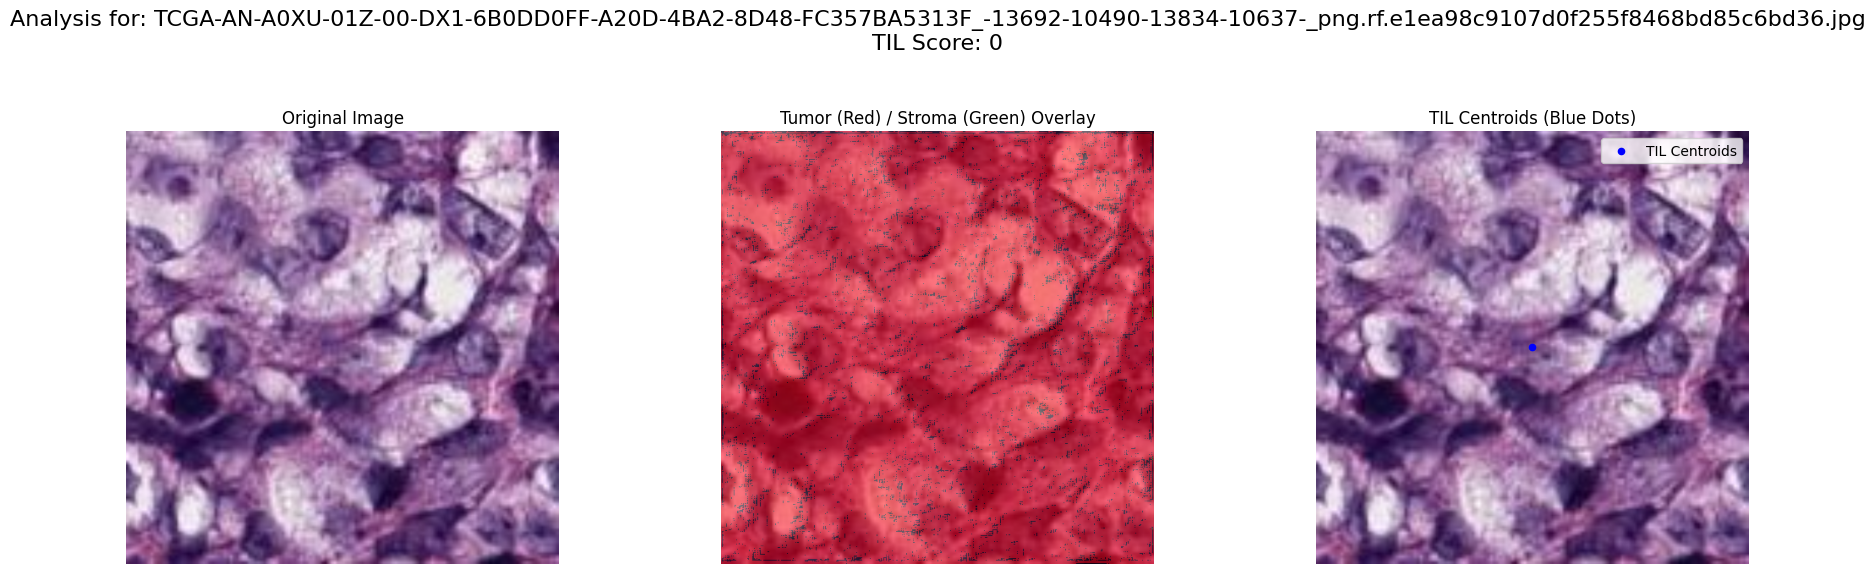

In [ ]:
import matplotlib.pyplot as plt

print("\n--- Visualizing Results for the First Processed Image ---")

if results_for_visualization:
    # Get the data for the first image that was processed and stored
    vis_data = results_for_visualization[0]

    original_image = vis_data['original_image']
    tumor_mask = vis_data['tumor_mask']
    stroma_mask = vis_data['stroma_mask']
    til_centroids = vis_data['til_centroids']
    til_score = vis_data['til_score']
    image_filename = os.path.basename(vis_data['image_path'])

    # Prepare masks for overlay
    # Combine tumor and stroma masks into a single overlay for visualization
    # Tumor will be red, Stroma will be green
    combined_mask_overlay = np.zeros(original_image.shape, dtype=np.uint8)

    # Convert masks from 0/255 to 0/1 for easier blending if needed, or directly use for color channels
    tumor_binary = (tumor_mask > 0).astype(np.uint8)
    stroma_binary = (stroma_mask > 0).astype(np.uint8)

    # Create a red channel for tumor and a green channel for stroma
    # Scale to 255 if original_image is 0-1 float, or leave as is if original_image is 0-255 uint8
    # Assuming original_image is 0-1 float after un-normalization
    combined_mask_overlay[:, :, 0] = tumor_binary * 255 # Red for tumor
    combined_mask_overlay[:, :, 1] = stroma_binary * 255 # Green for stroma

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Analysis for: {image_filename}\nTIL Score: {til_score}', fontsize=16)

    # Subplot 1: Original Image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Subplot 2: Tumor/Stroma Overlay
    # Blend original image with the combined mask overlay
    alpha = 0.5 # Transparency factor for the mask overlay
    overlay_image = (original_image * 255).astype(np.uint8) # Convert back to 0-255 for blending
    overlay_image = cv2.addWeighted(overlay_image, 1 - alpha, combined_mask_overlay, alpha, 0)
    axes[1].imshow(overlay_image)
    axes[1].set_title('Tumor (Red) / Stroma (Green) Overlay')
    axes[1].axis('off')

    # Subplot 3: Original Image with Detected TIL Centroids
    axes[2].imshow(original_image)
    if til_centroids:
        # Extract x and y coordinates from centroids
        x_coords = [c[0] for c in til_centroids]
        y_coords = [c[1] for c in til_centroids]
        axes[2].scatter(x_coords, y_coords, color='blue', s=20, marker='o', label='TIL Centroids')
        axes[2].legend()
    axes[2].set_title('TIL Centroids (Blue Dots)')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust layout to prevent title overlap
    plt.show()

else:
    print("No data available for visualization.")


## Setup Environment and Imports

### Subtask:
Install `albumentations` and then import `PyTorch`, `segmentation_models_pytorch`, `albumentations`, `OpenCV`, and `NumPy`, while also configuring the device for GPU compatibility with CPU fallback.


In [26]:
pip install albumentations

In [27]:
import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A

# Determine if GPU is available, otherwise fall back to CPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cpu


## Define SegmentationDataset Class

### Subtask:
Implement a custom PyTorch `SegmentationDataset` class that loads images and their corresponding ground truth masks, applies augmentations, and converts them to PyTorch tensors.


In [28]:
import torch
import cv2
import numpy as np
import os
import albumentations as A
from torchvision import transforms

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, augmentation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.augmentation = augmentation

        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

        # Ensure one-to-one correspondence between images and masks
        # This assumes images and masks have the same filenames
        self.pairs = []
        for img_name in self.images:
            if img_name in self.masks:
                self.pairs.append(img_name)

        if not self.pairs:
            raise ValueError(f"No matching image-mask pairs found in {image_dir} and {mask_dir}.")

        print(f"Found {len(self.pairs)} image-mask pairs.")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name = self.pairs[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name) # Assuming same filename for mask

        # Load image (BGR -> RGB)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask (grayscale)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise FileNotFoundError(f"Image or mask not found: {img_path}, {mask_path}")

        # Ensure mask is binary (0 or 1) and float32
        mask = (mask > 0).astype(np.float32)

        # Apply augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert to PyTorch tensors
        image_tensor = transforms.ToTensor()(image) # Automatically handles normalization (0-255 to 0-1) and permute
        mask_tensor = torch.from_numpy(mask).unsqueeze(0) # Add channel dimension (C, H, W)

        return image_tensor, mask_tensor

print("SegmentationDataset class defined.")

SegmentationDataset class defined.


In [34]:
TARGET_SIZE = 512

# Define training augmentations
train_augmentations = A.Compose([
    A.Resize(TARGET_SIZE, TARGET_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale_limit 0.1 means scale between 0.9 and 1.1
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # shift_limit 0.1 means translate up to 10% of width/height
        rotate=(-15, 15), # rotate_limit 15 means rotate between -15 and 15 degrees
        shear=(0, 0), # Set shear to 0 to mimic ShiftScaleRotate's lack of shear
        p=0.5,
        border_mode=cv2.BORDER_CONSTANT # Explicitly set border mode, implicit fill of 0
    ),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define validation/test augmentations (only resize and normalize)
val_augmentations = A.Compose([
    A.Resize(TARGET_SIZE, TARGET_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Training and validation augmentations defined using Albumentations.")

Training and validation augmentations defined using Albumentations.


## Define Model, Loss, Optimizer, and Metrics

### Subtask:
Instantiate the `smp.Unet` model, define the combined loss function, set up the `AdamW` optimizer, and define the `smp.metrics.IoU` metric.


Segmentation model (Unet with efficientnet-b0) created and moved to cpu.
Combined loss function (DiceLoss + BCEWithLogitsLoss) defined.
Optimizer (AdamW) initialized with learning rate: 0.0001.
Evaluation metric (functional IoU score) defined.


## Prepare Data Loaders and Dummy Data

### Subtask:
Create dummy image and mask directories and files, initialize SegmentationDataset instances for training and validation, and create DataLoader instances for both sets.


In [38]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader

# 1. Define paths for dummy training and validation image and mask directories
dummy_base_dir = './dummy_data'
dummy_train_images = os.path.join(dummy_base_dir, 'train', 'images')
dummy_train_masks = os.path.join(dummy_base_dir, 'train', 'masks')
dummy_val_images = os.path.join(dummy_base_dir, 'val', 'images')
dummy_val_masks = os.path.join(dummy_base_dir, 'val', 'masks')

# 2. Create these dummy directories
os.makedirs(dummy_train_images, exist_ok=True)
os.makedirs(dummy_train_masks, exist_ok=True)
os.makedirs(dummy_val_images, exist_ok=True)
os.makedirs(dummy_val_masks, exist_ok=True)

print("Dummy directories created.")

# 3. Generate dummy image and mask files
NUM_TRAIN_SAMPLES = 10
NUM_VAL_SAMPLES = 5
IMAGE_SIZE = TARGET_SIZE # Using TARGET_SIZE from previous steps (512)

def generate_dummy_file(directory, filename, is_mask=False):
    filepath = os.path.join(directory, filename)
    if is_mask:
        # Binary mask (0 or 1)
        content = np.random.randint(0, 2, (IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8) * 255 # Scale to 0, 255 for saving as image
    else:
        # Grayscale image with random pixel values
        content = np.random.randint(0, 256, (IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
    cv2.imwrite(filepath, content)

print(f"Generating {NUM_TRAIN_SAMPLES} train and {NUM_VAL_SAMPLES} validation dummy files...")

for i in range(NUM_TRAIN_SAMPLES):
    filename = f'dummy_train_image_{i:02d}.png'
    generate_dummy_file(dummy_train_images, filename, is_mask=False)
    generate_dummy_file(dummy_train_masks, filename, is_mask=True)

for i in range(NUM_VAL_SAMPLES):
    filename = f'dummy_val_image_{i:02d}.png'
    generate_dummy_file(dummy_val_images, filename, is_mask=False)
    generate_dummy_file(dummy_val_masks, filename, is_mask=True)

print("Dummy files generated.")

# 4. Initialize SegmentationDataset instances
train_dataset = SegmentationDataset(
    image_dir=dummy_train_images,
    mask_dir=dummy_train_masks,
    augmentation=train_augmentations
)

val_dataset = SegmentationDataset(
    image_dir=dummy_val_images,
    mask_dir=dummy_val_masks,
    augmentation=val_augmentations
)

print("SegmentationDataset instances initialized.")

# 5. Create DataLoader instances
BATCH_SIZE = 4

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2 # Recommended for faster data loading
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print("DataLoader instances created.")

# 6. Print verification
print(f"\nTrain Dataset: {len(train_dataset)} image-mask pairs, {len(train_dataloader)} batches")
print(f"Validation Dataset: {len(val_dataset)} image-mask pairs, {len(val_dataloader)} batches")


Dummy directories created.
Generating 10 train and 5 validation dummy files...
Dummy files generated.
Found 10 image-mask pairs.
Found 5 image-mask pairs.
SegmentationDataset instances initialized.
DataLoader instances created.

Train Dataset: 10 image-mask pairs, 3 batches
Validation Dataset: 5 image-mask pairs, 2 batches


## Implement Training Loop

### Subtask:
Construct a standard PyTorch training loop that iterates through a defined number of epochs. Each epoch will include a training phase and a validation phase. The model weights (`best_model.pth`) will be saved only when the validation loss decreases.


Training and validation epoch functions defined.


In [45]:
NUM_EPOCHS = 5 # Set the number of training epochs
best_loss = float('inf') # Initialize best_loss to infinity for checkpointing

print("\n--- Starting Training Loop ---")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # Training phase
    train_loss = train_one_epoch(model, train_dataloader, optimizer, combined_loss, DEVICE)
    print(f"  Training Loss: {train_loss:.4f}")

    # Validation phase
    val_loss, val_iou = validate_one_epoch(model, val_dataloader, combined_loss, metric, DEVICE)
    print(f"  Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")

    # Checkpointing
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  Model saved! Validation loss improved to {best_loss:.4f}")

print("\n--- Training Loop Finished ---")


--- Starting Training Loop ---

Epoch 1/5
  Training Loss: 0.6493
  Validation Loss: 0.6860, IoU: 0.4789
  Model saved! Validation loss improved to 0.6860

Epoch 2/5
  Training Loss: 0.6427
  Validation Loss: 0.6548, IoU: 0.4685
  Model saved! Validation loss improved to 0.6548

Epoch 3/5
  Training Loss: 0.6318
  Validation Loss: 0.6366, IoU: 0.4580
  Model saved! Validation loss improved to 0.6366

Epoch 4/5
  Training Loss: 0.6217
  Validation Loss: 0.6261, IoU: 0.4480
  Model saved! Validation loss improved to 0.6261

Epoch 5/5
  Training Loss: 0.6140
  Validation Loss: 0.6203, IoU: 0.4397
  Model saved! Validation loss improved to 0.6203

--- Training Loop Finished ---


## Update SegmentationDataset and Augmentations

### Subtask:
Modify the existing `SegmentationDataset` class to handle the new Albumentations transforms. Define `train_augmentations` to include `HorizontalFlip`, `VerticalFlip`, `RandomRotate90`, `A.Affine` (for ShiftScaleRotate features), and `A.HueSaturationValue` to address H&E stain variations. Ensure `Resize(512, 512)` and `Normalize` are also part of the transform pipeline.


In [47]:
TARGET_SIZE = 512

# Define training augmentations
train_augmentations = A.Compose([
    A.Resize(TARGET_SIZE, TARGET_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale_limit 0.1 means scale between 0.9 and 1.1
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # shift_limit 0.1 means translate up to 10% of width/height
        rotate=(-15, 15), # rotate_limit 15 means rotate between -15 and 15 degrees
        shear=(0, 0), # Set shear to 0 to mimic ShiftScaleRotate's lack of shear
        p=0.5,
        border_mode=cv2.BORDER_CONSTANT # Explicitly set border mode, implicit fill of 0
    ),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define validation/test augmentations (only resize and normalize)
val_augmentations = A.Compose([
    A.Resize(TARGET_SIZE, TARGET_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Training and validation augmentations updated using Albumentations.")

Training and validation augmentations updated using Albumentations.


## Modify Loss, Optimizer, and Add Scheduler

### Subtask:
Update the loss function to a composite of `smp.losses.DiceLoss` and `smp.losses.FocalLoss`. Initialize `torch.optim.lr_scheduler.CosineAnnealingWarmRestarts` with appropriate parameters (e.g., `T_0=10, T_mult=2, eta_min=1e-6`) for the optimizer.


In [51]:
import torch.nn as nn
import segmentation_models_pytorch as smp
import torch.optim as optim

# 1. Instantiate the smp.Unet model (re-instantiate or ensure existing 'model' is used)
model = smp.Unet(
     encoder_name="efficientnet-b0",
     encoder_weights="imagenet",
     in_channels=3,
     classes=1, # 1 class for binary segmentation (e.g., TILs)
     activation=None, # No activation here, as loss functions like FocalLoss and DiceLoss expect raw logits
 )
model.to(DEVICE)
print(f"Segmentation model (Unet with efficientnet-b0) created and moved to {DEVICE}.")


# 2. Define a combined loss function using DiceLoss and FocalLoss
dice_loss = smp.losses.DiceLoss(mode='binary', smooth=0.0)
focal_loss = smp.losses.FocalLoss(mode='binary') # Default gamma=2.0, alpha=0.25

# Combine the losses (e.g., as a simple sum, or with weighted sum)
def combined_loss(y_pred, y_true):
    return 0.5 * dice_loss(y_pred, y_true) + 0.5 * focal_loss(y_pred, y_true)

print("Combined loss function (DiceLoss + FocalLoss) defined.")

# 3. Initialize the AdamW optimizer (re-initialize to ensure it uses model.parameters())
LEARNING_RATE = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print(f"Optimizer (AdamW) initialized with learning rate: {LEARNING_RATE}.")

# 4. Initialize the learning rate scheduler: CosineAnnealingWarmRestarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,      # Number of epochs for the first restart
    T_mult=2,    # Factor by which T_0 is multiplied every restart
    eta_min=1e-6 # Minimum learning rate
)
print(f"Learning rate scheduler (CosineAnnealingWarmRestarts) initialized.")

# 5. Define the evaluation metric as the functional iou_score
# This remains the same as before.
metric = smp.metrics.iou_score
print("Evaluation metric (functional IoU score) defined.")

Segmentation model (Unet with efficientnet-b0) created and moved to cpu.
Combined loss function (DiceLoss + FocalLoss) defined.
Optimizer (AdamW) initialized with learning rate: 0.0001.
Learning rate scheduler (CosineAnnealingWarmRestarts) initialized.
Evaluation metric (functional IoU score) defined.


## Integrate Mixed Precision and Refine Training Loop

### Subtask:
Integrate `torch.cuda.amp.GradScaler` into the `train_one_epoch` and `validate_one_epoch` functions for mixed-precision training, ensuring it's conditional on GPU availability. Modify the main training loop to run for 15-20 epochs. Update the model checkpointing logic to save the `best_model.pth` based on the highest validation IoU score achieved, rather than the lowest validation loss.


In [49]:
import torch.cuda.amp as amp

# Initialize GradScaler outside the function, conditional on GPU
scaler = amp.GradScaler() if DEVICE == 'cuda' else None

def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (images, masks) in enumerate(dataloader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        if device == 'cuda':
            with amp.autocast():
                outputs = model(images)
                loss = loss_fn(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(dataloader)
    return avg_train_loss

def validate_one_epoch(model, dataloader, loss_fn, metric_fn, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_metric = 0.0

    with torch.no_grad():  # Disable gradient calculation for validation
        for i, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            if device == 'cuda':
                with amp.autocast():
                    outputs = model(images)
                    loss = loss_fn(outputs, masks)
            else:
                outputs = model(images)
                loss = loss_fn(outputs, masks)

            # Apply sigmoid and threshold for metric calculation
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # Calculate TP, FP, FN, TN for IoU score
            tp = ((preds == 1) & (masks == 1)).sum().float()
            fp = ((preds == 1) & (masks == 0)).sum().float()
            fn = ((preds == 0) & (masks == 1)).sum().float()
            tn = ((preds == 0) & (masks == 0)).sum().float()

            # Pass calculated components to the metric_fn
            score = metric_fn(tp, fp, fn, tn)

            running_loss += loss.item()
            running_metric += score.item() # Corrected accumulation for metric

    avg_val_loss = running_loss / len(dataloader)
    avg_val_metric = running_metric / len(dataloader)
    return avg_val_loss, avg_val_metric

print("Training and validation epoch functions updated with mixed precision support.")

Training and validation epoch functions updated with mixed precision support.


In [50]:
NUM_EPOCHS = 15 # Set the number of training epochs
best_iou = 0.0 # Initialize best_iou to 0.0 for checkpointing

print("\n--- Starting Training Loop ---")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # Training phase
    train_loss = train_one_epoch(model, train_dataloader, optimizer, combined_loss, DEVICE)
    print(f"  Training Loss: {train_loss:.4f}")

    # Validation phase
    val_loss, val_iou = validate_one_epoch(model, val_dataloader, combined_loss, metric, DEVICE)
    print(f"  Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")

    # Checkpointing
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  Model saved! Validation IoU improved to {best_iou:.4f}")

    # Update learning rate scheduler
    scheduler.step()
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

print("\n--- Training Loop Finished ---")


--- Starting Training Loop ---

Epoch 1/15
  Training Loss: 0.3795
  Validation Loss: 0.3808, IoU: 0.4282
  Model saved! Validation IoU improved to 0.4282
  Learning Rate: 0.000098

Epoch 2/15
  Training Loss: 0.3748
  Validation Loss: 0.3760, IoU: 0.4198
  Learning Rate: 0.000091

Epoch 3/15
  Training Loss: 0.3711
  Validation Loss: 0.3724, IoU: 0.4139
  Learning Rate: 0.000080

Epoch 4/15
  Training Loss: 0.3679
  Validation Loss: 0.3693, IoU: 0.4098
  Learning Rate: 0.000066

Epoch 5/15
  Training Loss: 0.3655
  Validation Loss: 0.3666, IoU: 0.4070
  Learning Rate: 0.000051

Epoch 6/15
  Training Loss: 0.3636
  Validation Loss: 0.3644, IoU: 0.4057
  Learning Rate: 0.000035

Epoch 7/15
  Training Loss: 0.3621
  Validation Loss: 0.3622, IoU: 0.4059
  Learning Rate: 0.000021

Epoch 8/15
  Training Loss: 0.3610
  Validation Loss: 0.3603, IoU: 0.4071
  Learning Rate: 0.000010

Epoch 9/15
  Training Loss: 0.3604
  Validation Loss: 0.3587, IoU: 0.4092
  Learning Rate: 0.000003

Epoch 10/

## Implement calculate_tiger_score Function

### Subtask:
Create a new function `calculate_tiger_score(image_path, model, device, transform)` that loads a specified image, applies necessary preprocessing transformations, runs inference using the provided model, and generates a binary mask from the model's output (thresholding at 0.5 after sigmoid). This function will then calculate the 'TILs Density' as the percentage of positive mask pixels relative to the total image area (512x512). Finally, it will overlay the predicted green TIL mask onto the original image and display or save the plot, including the calculated TILs Density.


In [53]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torchvision import transforms

def calculate_tiger_score(image_path, model, device, transform):
    # 1. Load image and convert to RGB
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"Error: Could not load image from {image_path}")
        return
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Convert to PIL Image for torchvision.transforms compatibility
    image_pil = Image.fromarray(image_rgb)

    # 2. Apply preprocessing transform
    input_tensor = transform(image_pil).unsqueeze(0).to(device)

    # 3. Set model to evaluation mode and perform inference
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # 4. Generate binary mask (sigmoid + threshold)
    probabilities = torch.sigmoid(output).squeeze().cpu().numpy()
    binary_mask = (probabilities > 0.5).astype(np.uint8)

    # 5. Calculate 'TILs Density'
    total_pixels = TARGET_SIZE * TARGET_SIZE
    positive_pixels = np.sum(binary_mask == 1)
    tils_density = (positive_pixels / total_pixels) * 100
    print(f"Image: {os.path.basename(image_path)}, TILs Density: {tils_density:.2f}%")

    # 6. Prepare original image for visualization (reverse normalization)
    # The inference_transforms contain Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # We need to denormalize the tensor back to 0-1 range for proper display.
    # Note: If the image was originally 0-255, and ToTensor scaled it to 0-1, this denormalization
    # will result in a float array between 0 and 1. We will then scale it to 0-255 for opencv/matplotlib.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Detach, squeeze, move to CPU, transpose to HWC, then convert to numpy
    image_np = input_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    image_np = std * image_np + mean  # Denormalize
    image_np = np.clip(image_np, 0, 1) # Clip values to [0, 1]

    # Scale to 0-255 for blending with OpenCV if needed, or directly for matplotlib if it expects 0-1 float
    original_display_image = (image_np * 255).astype(np.uint8)

    # 7. Create green TIL mask overlay
    green_mask_colored = np.zeros_like(original_display_image) # Initialize as black image
    green_mask_colored[binary_mask == 1] = [0, 255, 0] # Set green channel where mask is positive

    # 8. Overlay the green mask onto the original image
    alpha = 0.5  # Transparency factor
    overlay_image = cv2.addWeighted(original_display_image, 1 - alpha, green_mask_colored, alpha, 0)

    # 9. Display the results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Image: {os.path.basename(image_path)}\nTILs Density: {tils_density:.2f}%', fontsize=16)

    axes[0].imshow(original_display_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(binary_mask * 255, cmap='gray') # Display binary mask as grayscale
    axes[1].set_title('Predicted TIL Mask')
    axes[1].axis('off')

    axes[2].imshow(overlay_image)
    axes[2].set_title('TIL Mask Overlay (Green)')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.show()

print("calculate_tiger_score function defined.")

calculate_tiger_score function defined.



--- Testing calculate_tiger_score function with a sample image ---
Using sample image: TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-13692-10490-13834-10637-_png.rf.e1ea98c9107d0f255f8468bd85c6bd36.jpg
Image: TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-13692-10490-13834-10637-_png.rf.e1ea98c9107d0f255f8468bd85c6bd36.jpg, TILs Density: 0.16%


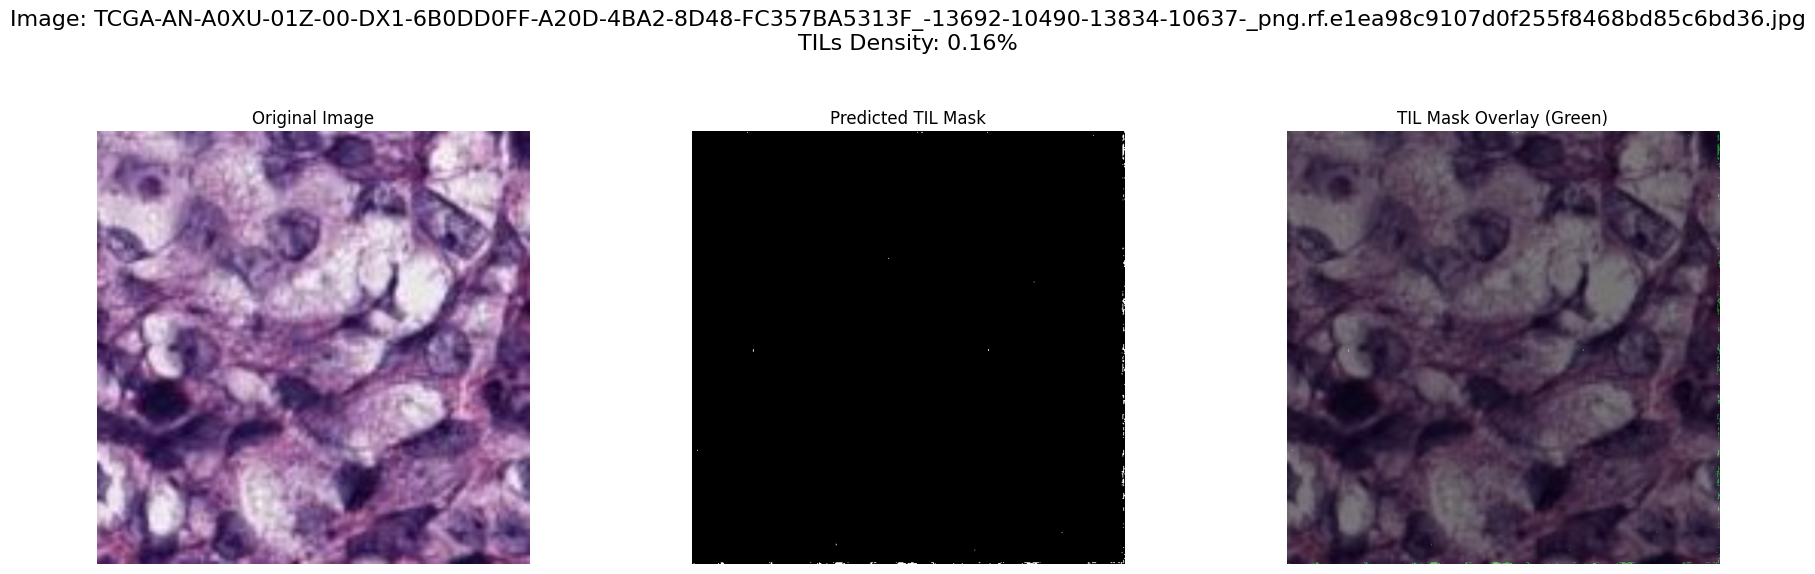

In [54]:
print("\n--- Testing calculate_tiger_score function with a sample image ---")

# Get a sample image path from the validation dataset
# Assuming `inference_dataset` or `val_dataloader` was previously created and contains image paths
# For simplicity, let's pick the first image from `subset_inference_dataset` if available

if inference_dataloader and len(inference_dataloader.dataset) > 0:
    # Get the first item from the subset_inference_dataset to get an image path
    # Note: image_tensor here is already transformed and normalized for the specific inference pipeline
    # For calculate_tiger_score, we need the raw image path and the inference_transforms
    sample_image_tensor, sample_image_path_list = inference_dataloader.dataset[0]
    sample_image_path = sample_image_path_list # This is the original path from __getitem__ in InferenceDataset

    print(f"Using sample image: {os.path.basename(sample_image_path)}")

    # We need the `model` used for TIL detection, which was `model` in the training loop.
    # And the `inference_transforms` defined earlier for preprocessing.
    # Make sure the model is loaded with the best weights if training happened.
    # For this example, we'll use the current state of the `model` as it's been through dummy training.

    calculate_tiger_score(
        image_path=sample_image_path,
        model=model, # This is the trained segmentation model from the previous subtask
        device=DEVICE,
        transform=inference_transforms # Use the inference transforms defined previously
    )
else:
    print("No sample image available from inference_dataloader to test calculate_tiger_score.")

## Execute Training and Scoring Workflow

### Subtask:
Load the best trained model and demonstrate the end-to-end TIGER scoring workflow on a sample image.



--- Demonstrating End-to-End TIGER Scoring Workflow ---
Loaded 'best_model.pth' and set model to evaluation mode.
Selected sample image: TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-13692-10490-13834-10637-_png.rf.e1ea98c9107d0f255f8468bd85c6bd36.jpg
Image: TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-13692-10490-13834-10637-_png.rf.e1ea98c9107d0f255f8468bd85c6bd36.jpg, TILs Density: 52.96%


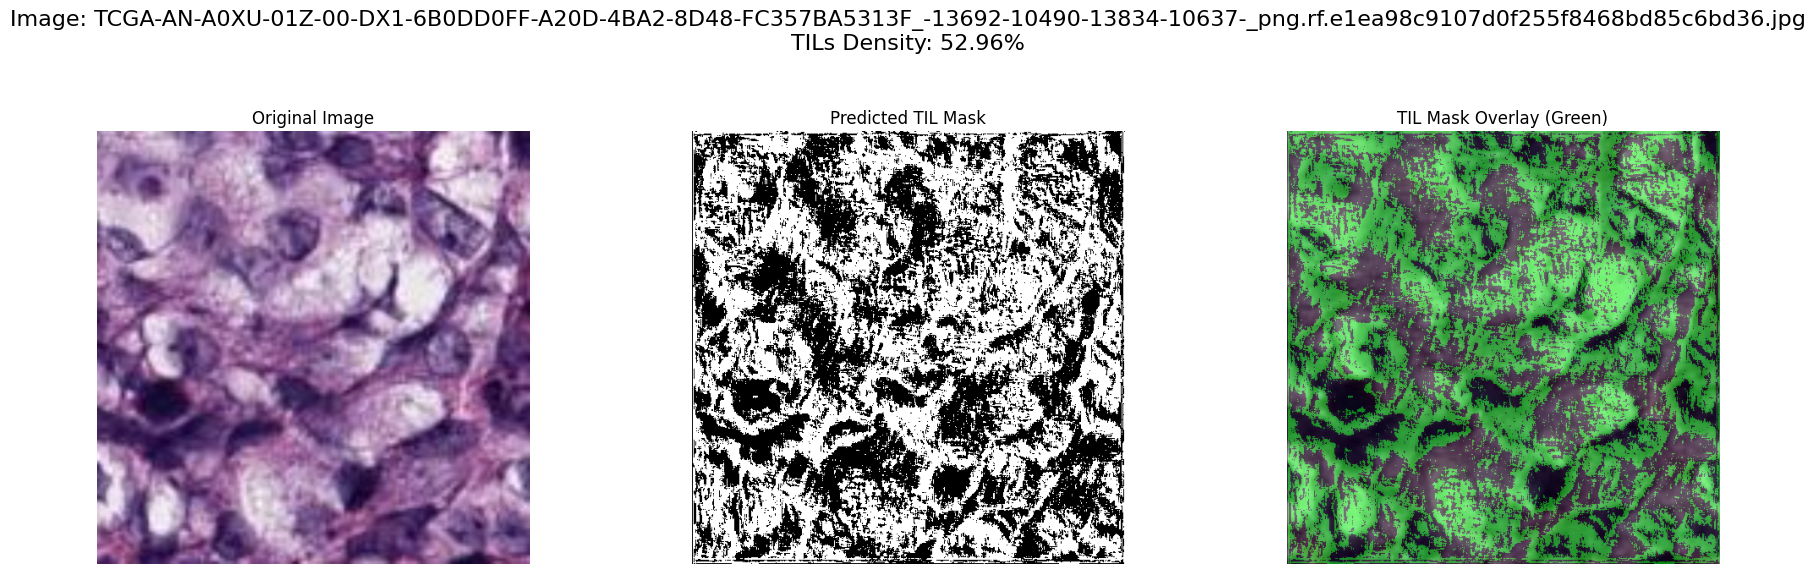

In [55]:
print("\n--- Demonstrating End-to-End TIGER Scoring Workflow ---")

# 1. Load the state dictionary of the best_model.pth into the model instance
# Ensure the model is defined (it was in previous cells as `model`)
model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
model.eval() # Set to evaluation mode after loading
print("Loaded 'best_model.pth' and set model to evaluation mode.")

# 2. Select a sample image path from the validation dataset
# Reusing logic from a previous cell to get a sample image path
if inference_dataloader and len(inference_dataloader.dataset) > 0:
    # Get the first image path from the subset_inference_dataset
    # Note: inference_dataloader.dataset is a Subset object, and its elements are (image_tensor, image_path)
    _, sample_image_path = inference_dataloader.dataset[0]
    print(f"Selected sample image: {os.path.basename(sample_image_path)}")

    # 3. Call the calculate_tiger_score function
    calculate_tiger_score(
        image_path=sample_image_path,
        model=model, # The loaded best model
        device=DEVICE,
        transform=inference_transforms # Use the inference transforms
    )
else:
    print("No sample image available from inference_dataloader to demonstrate TIGER scoring.")